In [129]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [130]:
# read LMP data from csv into a new dataframe
prices = pd.read_csv('../data/prices_raw.csv')

# reindex and drop unused index columns
prices.index = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-31 23:00:00',freq='h')
prices = prices.drop(['Date','Hour Ending'],axis=1)

# interpolate over missing values (only 10 total)
prices = prices.interpolate(method='linear')

In [131]:
# load actual electricity demand data
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')
elec.drop('Davenport',axis=1,inplace=True)
elec_total = pd.DataFrame(elec.sum(axis=1).values,columns=['Actual'],index=elec.index)

# load forecasted electricity demand data
forecast = pd.read_csv('../data/elec_forecast.csv',index_col=0)
forecast.index = pd.to_datetime(forecast.index,format='%Y-%m-%d %H:00:00')

In [135]:
# populate columns
totals = pd.DataFrame(forecast['aggregate_forecast'].values/1000,columns=['Forecast MWh'],index=forecast.index)
totals = totals.join(prices).join(elec_total/1000)

totals = totals.rename({'Day Ahead LMP':'DA $/MWh',
                        'Real Time LMP':'RT $/MWh',
                        'Actual':'Actual MWh',
                       },axis='columns')

totals['DA Charge $'] = (totals['Forecast MWh'])*totals['DA $/MWh']
totals['Error MWh'] = totals['Actual MWh'] - totals['Forecast MWh']
totals['RT Charge $'] = (totals['Error MWh'])*totals['RT $/MWh']
totals['Net Charge $'] = totals['DA Charge $'] + totals['RT Charge $']

totals = totals[['Forecast MWh','DA $/MWh','DA Charge $',
                 'Actual MWh','RT $/MWh','RT Charge $',
                 'Error MWh','Net Charge $']]
totals.head(3)

,Forecast MWh,DA $/MWh,DA Charge $,Actual MWh,RT $/MWh,RT Charge $,Error MWh,Net Charge $
2018-01-11 00:00:00,0.696068,70.44,49.031024,0.7109,59.18,0.877763,0.014832,49.908787
2018-01-11 01:00:00,0.682695,69.91,47.727188,0.7160,45.32,1.509395,0.033305,49.236583
2018-01-11 02:00:00,0.609783,64.01,39.032180,0.6386,29.07,0.837724,0.028817,39.869904


In [137]:
totals.sum()

Forecast MWh      3660.958736
DA $/MWh        171703.950000
DA Charge $     148677.483534
Actual MWh        3673.607600
RT $/MWh        164210.710000
RT Charge $        813.686822
Error MWh           12.648864
Net Charge $    149491.170356
dtype: float64

12648.863685686389

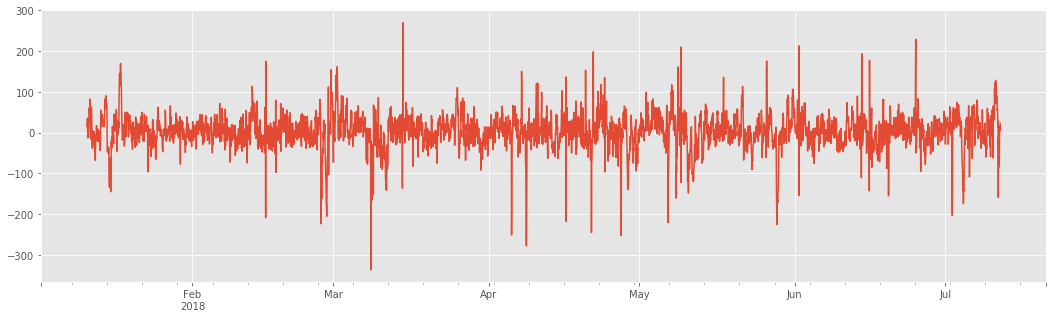

In [133]:
# totals['Net Charge $'].plot(figsize=(18,5))
totals['Error kWh'].plot(figsize=(18,5))

totals['Error kWh'].sum()

In [128]:
avg_rate = np.round((totals['Net Charge $'].sum()/totals['Actual kWh'].sum())*100,2)
rate_estimate = 6 # estimate for yale's current rate in cents/kWh

savings = np.round(((rate_estimate - avg_rate) * totals['Actual kWh'].sum())/100,2)
yearly_savings = np.round(savings*(8760/len(totals)),2)

print('The average day-ahead rate is {} cents/kWh.\n'
      .format(avg_rate))
print('Assuming a current rate of {} cents/kWh, this strategy would save ${} per year.'
      .format(rate_estimate, yearly_savings))


The average day-ahead rate is 4.07 cents/kWh.

Assuming a current rate of 6 cents/kWh, this strategy would save $142190.82 per year.
